In [25]:
# Configuration file to manage API keys as environment variables
from dotenv import load_dotenv

# Load API key information
load_dotenv(override=True)

True

## Evaluation of Response Obtained using the askmcq System

## 1. Model: gpt-4o-mini, Retriever: MultiQueryRetriever

In [26]:

import os

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json


from sklearn.metrics.pairwise import cosine_similarity
from openai import  OpenAI




We used the given setting to obtain the response of mcq. Since the `ground_truth_context` and `reasoning` was obtained from LLM directly without any expert knowledge, We would assume the LLM to be providing correct answer and is not misinterpreting the things.

In [27]:
# import required libaries


open.api_key = os.getenv("OPENAI_API_KEY")

# Intialize OpenAI client
client = OpenAI()

# Function to get embeddings from OpenAI
def get_embedding(text_to_embed):
	# Embed a line of text
	response = client.embeddings.create(
    	model= "text-embedding-3-small",
    	input=[text_to_embed]
	)
	# Extract the AI output embedding as a list of floats
	embedding = response.data[0].embedding
    
	return embedding

# Function to calculate context similarity
def calculate_similarity(model_context, ground_truth_context):
    model_embedding = get_embedding(model_context)
    ground_truth_embedding = get_embedding(ground_truth_context)
    similarity = cosine_similarity([model_embedding], [ground_truth_embedding])[0][0]
    return similarity


# Sample dataset results_base_with_gt.json

with open("../outputs/output_1_basemodel_eval.json", "r") as file:
    data = json.load(file)



# Process data and calculate scores
results = []
for entry in data:
    
    if  "evaluation_metrics" in entry: # skip evaluation metrics
            continue
    
    context_score = calculate_similarity(entry["context"], entry["ground_truth_context"])
    reasoning_score = calculate_similarity(entry["model_reasoning"], entry["reasoning_ground_truth"])

    
    results.append({"Context Similarity": context_score, "Reasoning Quality": reasoning_score})


df = pd.DataFrame(results) # a dataframe of individual reponse scores


In [28]:
response_df = pd.DataFrame(data)

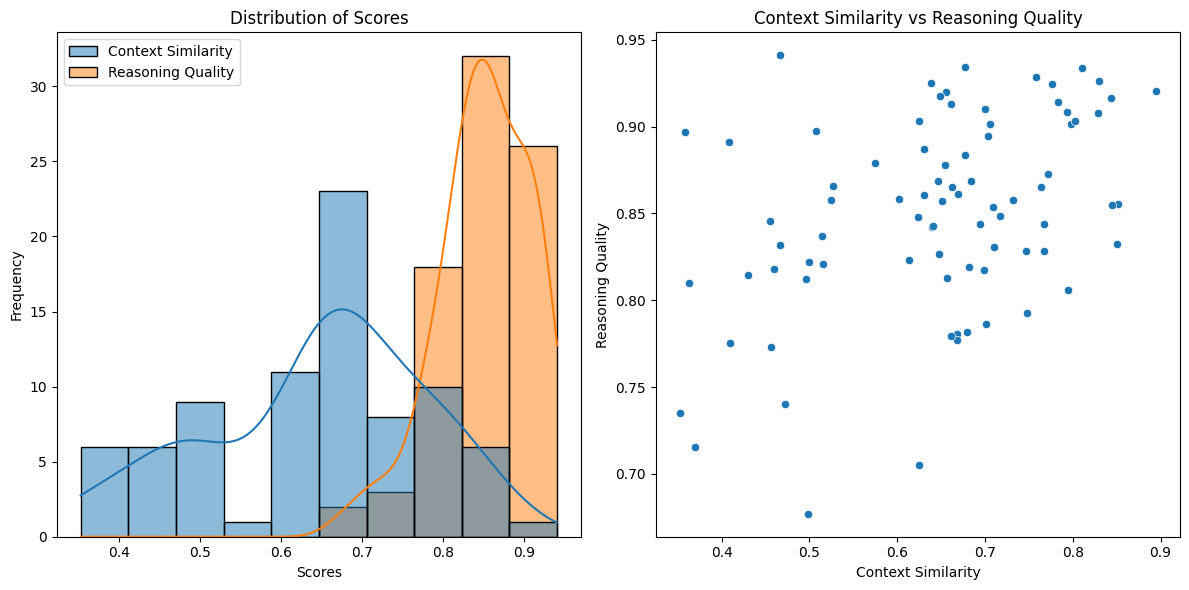

In [29]:

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for scores
plt.subplot(1, 2, 1)
sns.histplot(df, bins=10, kde=True)
plt.title("Distribution of Scores")
plt.xlabel("Scores")
plt.ylabel("Frequency")

# Scatter plot for context vs reasoning
plt.subplot(1, 2, 2)
sns.scatterplot(x="Context Similarity", y="Reasoning Quality", data=df)
plt.title("Context Similarity vs Reasoning Quality")
plt.xlabel("Context Similarity")
plt.ylabel("Reasoning Quality")

plt.tight_layout()
plt.show()


In [30]:
response_df.head()

,question,context,ground_truth_context,model_answer,model_answer_idx,correct_answer_text,correct_answer_idx,model_reasoning,reasoning_ground_truth,is_correct,evaluation_metrics
0,A 68-year-old male with a history of hypertens...,"urea level, respiratory rate, blood pressure, ...","In addition to clinical judgement, we recommen...",B,1.0,Pneumonia Severity Index (PSI) preferentially ...,1.0,According to the guidelines for managing commu...,The guidelines for CAP recommend using a valid...,True,NaN
1,A 55-year-old female with a history of chronic...,"In this section, we describe the overall appro...",The initial test for the evaluation of GFR is ...,A,0.0,Measure cystatin C to calculate eGFRcr-cys,0.0,According to the guidelines for evaluating glo...,"According to the CKD guidelines, the initial t...",True,NaN
2,A 70-year-old male with a history of a recent ...,Guidelines from the cardiology community provi...,patients with a history of acute coronary synd...,B,1.0,Transition to single antiplatelet therapy.,1.0,According to the guidelines referenced in the ...,"According to the guidelines, patients with a h...",True,NaN
3,A 35-year-old female presents with a 5-day his...,Oral decongestants may provide symptomatic rel...,Extension of watchful waiting (without antibio...,B,1.0,Watchful waiting without antibiotics,1.0,According to the guidelines for managing uncom...,The guidelines recommend that the initial mana...,True,NaN
4,A 40-year-old male presents to the emergency d...,The second-therapy phase should begin when the...,"In adults with convulsive status epilepticus, ...",B,1.0,Intramuscular midazolam,1.0,According to the guidelines for treating convu...,"For convulsive status epilepticus, the guideli...",True,NaN


In [31]:
def visualize_metrics(data):
    # Extracting evaluation metrics
    accuracy = data['evaluation_metrics']['accuracy']
    total = data['evaluation_metrics']['total']
    correct = data['evaluation_metrics']['correct']
    
    # Extracting the confusion matrix
    confusion_matrix = data['evaluation_metrics']['confusion_matrix']
    
    # Displaying the metrics as text
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Total: {total}")
    print(f"Correct Predictions: {correct}")
    
    # Convert confusion matrix to DataFrame for easier manipulation and visualization
    confusion_df = pd.DataFrame(confusion_matrix)
    
    # Plotting the confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [33]:
data[81]['evaluation_metrics']

{'accuracy': 1.0,
 'total': 81,
 'correct': 81,
 'confusion_matrix': {'Pred A': {'True A': 13,
   'True B': 0,
   'True C': 0,
   'True D': 0},
  'Pred B': {'True A': 0, 'True B': 25, 'True C': 0, 'True D': 0},
  'Pred C': {'True A': 0, 'True B': 0, 'True C': 39, 'True D': 0},
  'Pred D': {'True A': 0, 'True B': 0, 'True C': 0, 'True D': 4}}}

Accuracy: 1.00
Total: 81
Correct Predictions: 81


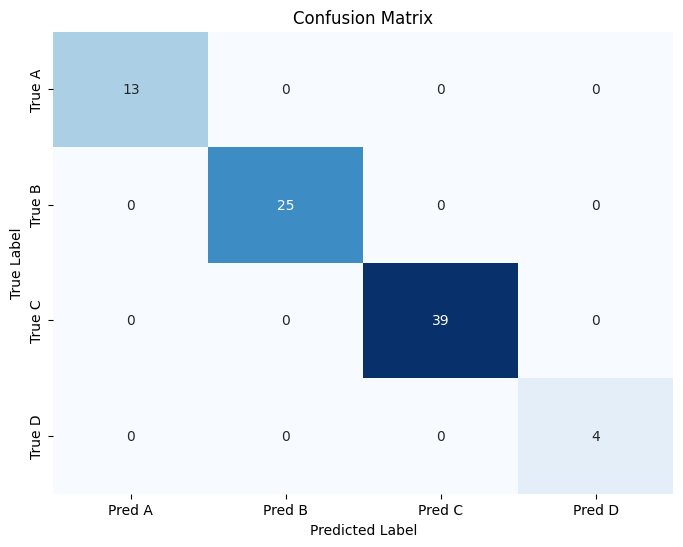

In [34]:
visualize_metrics(data[81])

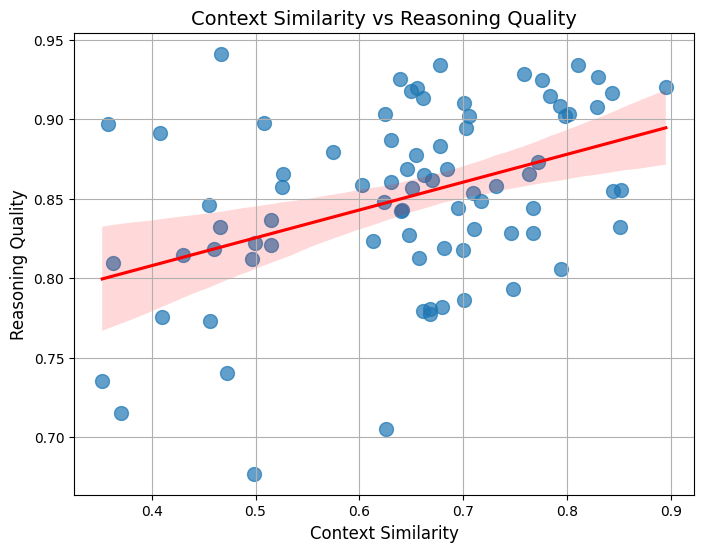

In [35]:
# Create DataFrame
# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    x="Context Similarity", 
    y="Reasoning Quality", 
    data=df, 
    scatter_kws={'s': 100, 'alpha': 0.7}, 
    line_kws={'color': 'red'}
)
plt.title("Context Similarity vs Reasoning Quality", fontsize=14)
plt.xlabel("Context Similarity", fontsize=12)
plt.ylabel("Reasoning Quality", fontsize=12)
plt.grid(True)
plt.show()


## 2. Model: gpt-4o-min, Query: Single retrierval with similarity score +recrusive text based chunking


In [10]:
import json
import pandas as pd


with open("../after_evaluation_similarity.json", "r") as file:
    data = json.load(file)
df = pd.DataFrame(data)


We used the given setting to obtain the response of mcq. Since the `ground_truth_context` and `reasoning` was obtained from LLM directly without any expert knowledge, We would assume the LLM to be providing correct answer and is not misinterpreting the things.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import json
from openai import  OpenAI
import os


In [23]:
# import required libaries



open.api_key = os.getenv("OPENAI_API_KEY")

# Intialize OpenAI client
client = OpenAI()

# Function to get embeddings from OpenAI
def get_embedding(text_to_embed):
	# Embed a line of text
	response = client.embeddings.create(
    	model= "text-embedding-3-small",
    	input=[text_to_embed]
	)
	# Extract the AI output embedding as a list of floats
	embedding = response.data[0].embedding
    
	return embedding

# Function to calculate context similarity
def calculate_similarity(model_context, ground_truth_context):
    model_embedding = get_embedding(model_context)
    ground_truth_embedding = get_embedding(ground_truth_context)
    similarity = cosine_similarity([model_embedding], [ground_truth_embedding])[0][0]
    return similarity


# Sample dataset results_base_with_gt.json
with open("../outputs/output_2_similarity.json", "r") as file:
    data = json.load(file)

# Process data and calculate scores
results = []
for entry in data:
    
    if  "evaluation_metrics" in entry: # skip evaluation metrics
            continue
    
    context_score = calculate_similarity(entry["context"], entry["ground_truth_context"])
    reasoning_score = calculate_similarity(entry["model_reasoning"], entry["reasoning_ground_truth"])

    
    results.append({"Context Similarity": context_score, "Reasoning Quality": reasoning_score})


df = pd.DataFrame(results) # a dataframe of individual reponse scores


In [13]:
response_df = pd.DataFrame(data)

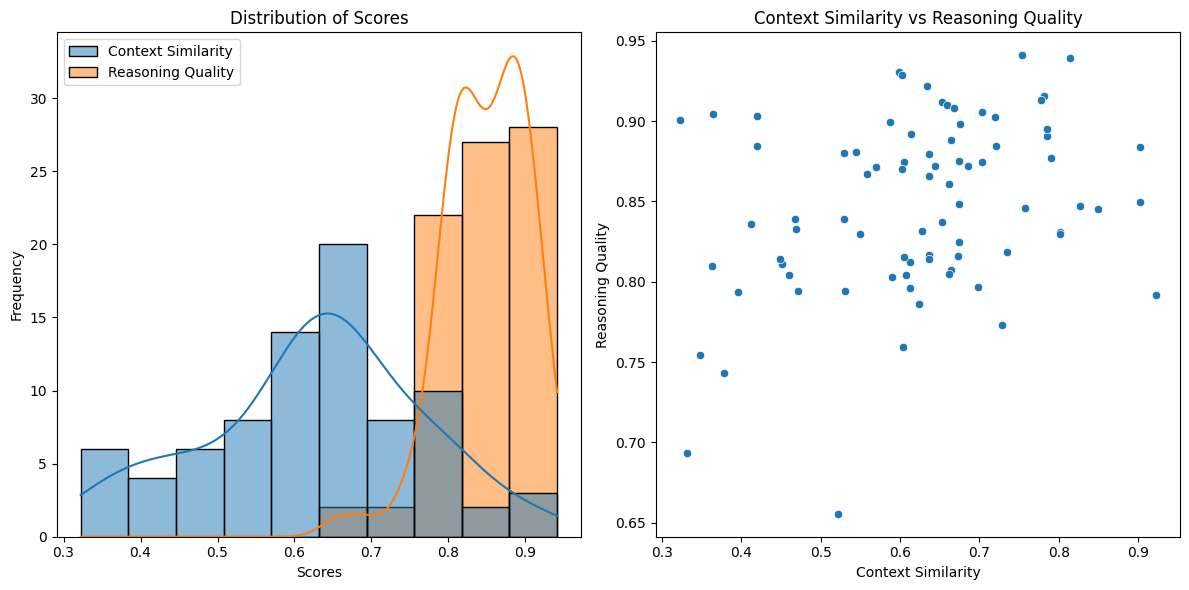

In [14]:

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for scores
plt.subplot(1, 2, 1)
sns.histplot(df, bins=10, kde=True)
plt.title("Distribution of Scores")
plt.xlabel("Scores")
plt.ylabel("Frequency")

# Scatter plot for context vs reasoning
plt.subplot(1, 2, 2)
sns.scatterplot(x="Context Similarity", y="Reasoning Quality", data=df)
plt.title("Context Similarity vs Reasoning Quality")
plt.xlabel("Context Similarity")
plt.ylabel("Reasoning Quality")

plt.tight_layout()
plt.show()


In [15]:
response_df.head()

,question,context,ground_truth_context,model_answer,model_answer_idx,correct_answer_text,correct_answer_idx,model_reasoning,reasoning_ground_truth,is_correct,evaluation_metrics
0,A 68-year-old male with a history of hypertens...,"urea level, respiratory rate, blood pressure, ...","In addition to clinical judgement, we recommen...",B,1.0,Pneumonia Severity Index (PSI) preferentially ...,1.0,According to the guidelines for community-acqu...,The guidelines for CAP recommend using a valid...,True,NaN
1,A 55-year-old female with a history of chronic...,Following incidental detection of elevated uri...,The initial test for the evaluation of GFR is ...,A,0.0,Measure cystatin C to calculate eGFRcr-cys,0.0,"In this scenario, the patient has a history of...","According to the CKD guidelines, the initial t...",True,NaN
2,A 70-year-old male with a history of a recent ...,|IIb|ASR|In patients with ACS treated with cor...,patients with a history of acute coronary synd...,B,1.0,Transition to single antiplatelet therapy.,1.0,"According to the guidelines, patients who have...","According to the guidelines, patients with a h...",True,NaN
3,A 35-year-old female presents with a 5-day his...,Oral decongestants may provide symptomatic rel...,Extension of watchful waiting (without antibio...,B,1.0,Watchful waiting without antibiotics,1.0,According to the guidelines for managing uncom...,The guidelines recommend that the initial mana...,True,NaN
4,A 40-year-old male presents to the emergency d...,The second-therapy phase should begin when the...,"In adults with convulsive status epilepticus, ...",B,1.0,Intramuscular midazolam,1.0,According to the guidelines for treating convu...,"For convulsive status epilepticus, the guideli...",True,NaN


In [16]:
def visualize_metrics(data):
    # Extracting evaluation metrics
    accuracy = data['evaluation_metrics']['accuracy']
    total = data['evaluation_metrics']['total']
    correct = data['evaluation_metrics']['correct']
    
    # Extracting the confusion matrix
    confusion_matrix = data['evaluation_metrics']['confusion_matrix']
    
    # Displaying the metrics as text
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Total: {total}")
    print(f"Correct Predictions: {correct}")
    
    # Convert confusion matrix to DataFrame for easier manipulation and visualization
    confusion_df = pd.DataFrame(confusion_matrix)
    
    # Plotting the confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [18]:
data[81]['evaluation_metrics']

{'accuracy': 1.0,
 'total': 81,
 'correct': 81,
 'confusion_matrix': {'Pred A': {'True A': 25,
   'True B': 0,
   'True C': 0,
   'True D': 0},
  'Pred B': {'True A': 0, 'True B': 39, 'True C': 0, 'True D': 0},
  'Pred C': {'True A': 0, 'True B': 0, 'True C': 4, 'True D': 0},
  'Pred D': {'True A': 0, 'True B': 0, 'True C': 0, 'True D': 0}}}

Accuracy: 1.00
Total: 81
Correct Predictions: 81


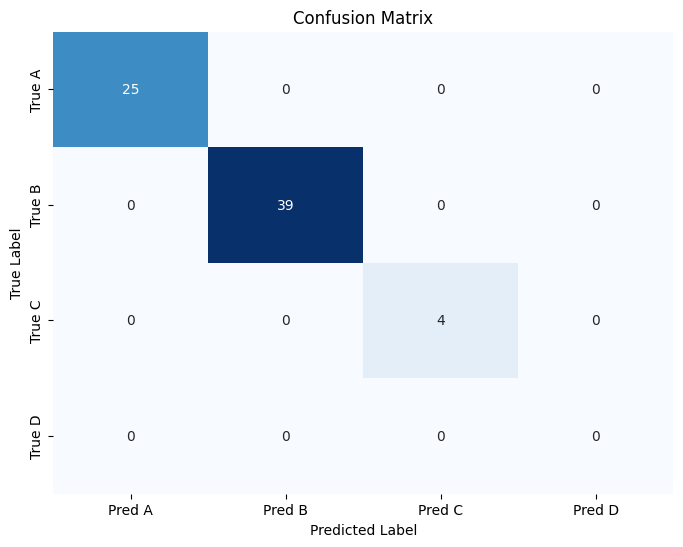

In [20]:
visualize_metrics(data[81])

## 2. Model: gpt-4o-min, Query: Multi /MMR + semantic chunking


In [24]:
# Temp code


def evaluate_model(questions_data):
    """
    Evaluates the model's performance and computes accuracy and confusion matrix.
    """
    total = 0
    correct = 0
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels

    for q in questions_data:
        # Ensure required fields exist
        if "correct_answer_idx" not in q or "model_answer_idx" not in q:
            print(f"Skipping question (missing fields): {q['question']}")
            continue

        # Compare with ground truth
        is_correct = (q["model_answer_idx"] == q["correct_answer_idx"])
        q["is_correct"] = is_correct

        # Update metrics
        total += 1
        if is_correct:
            correct += 1
        if q["correct_answer_idx"] is None:
            print(q)
        # Append to confusion matrix data
        y_true.append((q["correct_answer_idx"]))
        # print(y_true)
        y_pred.append((q["model_answer_idx"]))

    # Compute confusion matrix
    confusion = confusion_matrix(y_true, y_pred, labels=[0, 1,2, 3])
    confusion_df = pd.DataFrame(
        confusion,
        index=["True A", "True B", "True C", "True D"],
        columns=["Pred A", "Pred B", "Pred C", "Pred D"]
    )

    return {
        "accuracy": correct / total if total > 0 else 0,
        "total": total,
        "correct": correct,
        "confusion_matrix": confusion_df.to_dict()
    }
import json
from sklearn.metrics import confusion_matrix
import pandas as pd

# load data
with open ("../output_1_basemodel copy.json") as file:
    data = json.load(file)

evaluate_metric = evaluate_model(data)

evaluate_metric

data.append({
        "evaluation_metrics": evaluate_metric
    })

with open('output_1_basemodel_eval.json', "w") as f:
    json.dump(data, f, indent=2)
